# 02: Training

This notebook loads the data from the previous notebook and trains a model to predict forest attributes. The model is evaluated and saved to disk for later use.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
from sklearn.metrics import r2_score
import plotly.express as px
import numpy as np

from naip_cnn.data import NAIPDataset
from naip_cnn import models


tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load Data

Before training, we need load our data, split it into training and validation sets, and divide it into batches. Parameters like the dataset `name`, `shape`, `year`, and `n` are used to identify the dataset we previously exported, while the `bands`, `label`, and `train_split` and `val_split` can be used to adjust the loaded data by subsetting bands, choosing a different target variable, or modifying the split proportions. The batch size affects speed, memory usage, and model performance during training, and can be adjusted empirically.

In [99]:
# Dataset identifiers
NAME = "MAL2016_CanyonCreek"
FOOTPRINT_SIZE = (150, 150)

# Dataset modifiers
BANDS = ("R", "G", "B", "N")
LABEL = "cover"
BATCH_SIZE = 64
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1

In [100]:
ds = NAIPDataset(
    name=NAME,
    label=LABEL,
    shape=FOOTPRINT_SIZE,
    root_dir="../data/training",
    train_split=TRAIN_SPLIT,
    val_split=VAL_SPLIT,
)

train = (
    ds.load_train(bands=BANDS)
    .cache()
    .shuffle(buffer_size=10_000)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

val = (
    ds.load_val(bands=BANDS)
    .cache()
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE)
)

## Build and Train Model

With the data loaded, we can build a CNN model and train it. While training the model, we'll use two callbacks: 

- `EarlyStopping` interrupts training if loss stops improving after the number of epochs defined by `patience`. This can reduce training time by aborting once a model starts to overfit, when further epochs are unlikely to improve model performance. Lower `patience` values stop the model sooner, but may trigger prematurely due to random fluctuations in loss.
- `ModelCheckpoint` stores the weights of the best performing epoch, allowing us to restore the optimal model if later epochs begin to overfit. 

*Note that while `EarlyStopping` *can* restore weights, this only works if the callback is triggered, which may not happen if `patience` is not exceeded.*

In [107]:
NUM_EPOCHS = 25
MODEL_ID = f"{NAME}_{LABEL}_{''.join(BANDS)}"
CHECKPOINT_PATH = (  # ModelCheckpoint does not support .keras
    f"../models/checkpoint_{MODEL_ID}_UNet.h5"
)
MODEL_PATH = f"../models/model_{MODEL_ID}_UNet.keras"

In [108]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", verbose=1, patience=10, restore_best_weights=False
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=CHECKPOINT_PATH,
        save_best_only=True,
        save_weights_only=True,
        verbose=False,
        monitor="val_loss",
    ),
]

model = models.UNet(shape=(*FOOTPRINT_SIZE, len(BANDS)))
model.fit(
    train,
    verbose=1,
    validation_data=val,
    epochs=NUM_EPOCHS,
    callbacks=callbacks,
)

Epoch 1/25
232/232 [==============================] - 38s 42ms/step - loss: 327.3940 - val_loss: 191.3805
Epoch 2/25
232/232 [==============================] - 7s 30ms/step - loss: 181.4673 - val_loss: 178.9126
Epoch 3/25
232/232 [==============================] - 7s 30ms/step - loss: 159.3156 - val_loss: 162.2344
Epoch 4/25
232/232 [==============================] - 7s 30ms/step - loss: 147.8841 - val_loss: 163.1659
Epoch 5/25
232/232 [==============================] - 7s 30ms/step - loss: 139.7797 - val_loss: 156.8672
Epoch 6/25
232/232 [==============================] - 7s 30ms/step - loss: 132.3365 - val_loss: 157.2243
Epoch 7/25
232/232 [==============================] - 7s 30ms/step - loss: 127.8032 - val_loss: 159.4589
Epoch 8/25
232/232 [==============================] - 7s 30ms/step - loss: 121.1045 - val_loss: 148.6783
Epoch 9/25
232/232 [==============================] - 7s 30ms/step - loss: 117.6275 - val_loss: 145.1603
Epoch 10/25
232/232 [==============================] -

Once training is complete, we can restore the weights of the best epoch and store the entire model for later use.

In [109]:
model.load_weights(CHECKPOINT_PATH)
model.save(MODEL_PATH)

## Evaluate Model



We can use `evaluate` to get an idea of model performance.

In [110]:
model.evaluate(val);

29/29 [==============================] - 1s 13ms/step - loss: 139.5632


### Generate Predictions

For a closer look, we'll predict labels for our validation set that we can compare to the true labels.

In [111]:
y_pred = model.predict(val)
y_true = np.concatenate([data[1] for data in val.as_numpy_iterator()])

29/29 [==============================] - 1s 18ms/step


### Assess Correlation

Now we can calculate an R<sup>2</sup> to assess correlation between the predicted and actual values.

In [112]:
r2_score(y_true.ravel(), y_pred.ravel())

0.7818319735183653

A scatter-plot with a 1:1 line will further illustrate correlation.

In [113]:
fig = px.scatter(
    x=y_pred.ravel(),
    y=y_true.ravel(),
    labels={"x": "Predicted", "y": "True"},
    height=600,
    width=600,
    template="plotly_white",
    marginal_x="histogram",
    marginal_y="histogram",
)

# Add 1:1 line
fig.add_shape(
    type="line",
    x0=0,
    y0=0,
    x1=100,
    y1=100,
    line=dict(color="black", width=2, dash="dash"),
)

fig

### Preview Outputs

In [114]:
import matplotlib.pyplot as plt

In [115]:
X_ref = np.concatenate([data[0] for data in val.as_numpy_iterator()])

Text(0.5, 1.0, 'Cancov (pred)')

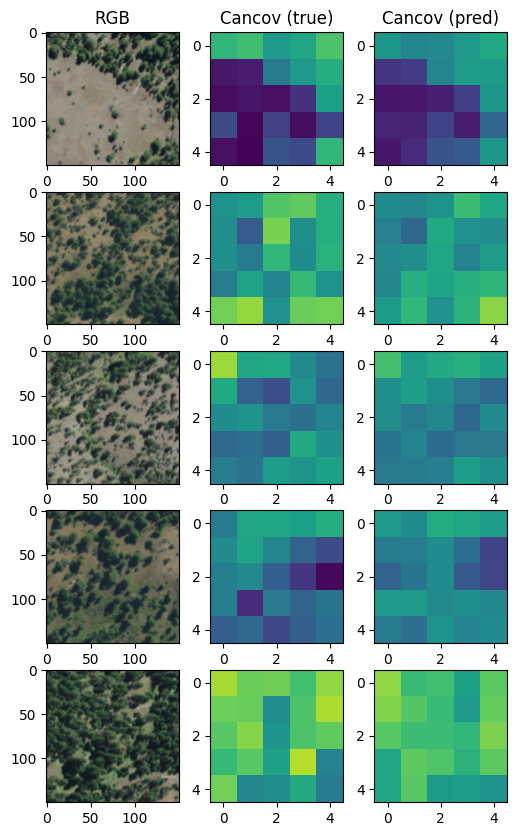

In [116]:
rng = np.random.default_rng(99)
check_samples = rng.choice(range(len(X_ref)), size=5, replace=False)

fig, ax = plt.subplots(len(check_samples), 3, figsize=(6, 2 * len(check_samples)))

for i, sample in enumerate(check_samples):
    ax[i, 0].imshow(X_ref[sample, ..., :3])
    ax[i, 1].imshow(y_true[sample, ...], vmin=0, vmax=100)
    ax[i, 2].imshow(y_pred[sample, ...], vmin=0, vmax=100)

ax[0, 0].set_title("RGB")
ax[0, 1].set_title("Cancov (true)")
ax[0, 2].set_title("Cancov (pred)")